In [81]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torchvision.transforms import v2

from sklearn.preprocessing import OneHotEncoder

from transformers import pipeline
from accelerate.test_utils.testing import get_backend
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, AutoImageProcessor, AutoModel, ResNetModel

In [82]:
dataset_path = Path("./Houses-dataset/Houses Dataset")
txt_dataset_path = dataset_path / "HousesInfo.txt"
uszip_path = Path("./data/uszips/uszips.csv")
out_folder = Path("./data/processed_text_data")

In [83]:
columns_name = ["Number of Bedrooms", "Number of bathrooms", "Area", "Zipcode", "Price"]
structured_df = pd.read_csv(txt_dataset_path, sep=' ', names=columns_name)

## Image Concatenation

Concatenation of the fourth images to create a single one for each house

### With Black background

In [8]:
out_folder = Path("./data/concatenated_images")
Path.mkdir(out_folder, parents=True, exist_ok=True)

In [9]:
def pad_image(image, target_width, target_height):
        padded_image = Image.new("RGB", (target_width, target_height), (0, 0, 0))  # Black background
        x_offset = (target_width - image.width) // 2
        y_offset = (target_height - image.height) // 2
        padded_image.paste(image, (x_offset, y_offset))
        return padded_image

In [10]:
def concatenate_imgs(images: list[Image]) -> Image:

    max_width = max(image.width for image in images)
    max_height = max(image.height for image in images)
    
    padded_images = [pad_image(img, max_width, max_height) for img in images]

    new_width = max_width * 2
    new_height = max_height * 2
    new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))  # Add a black background

    new_image.paste(padded_images[0], (0, 0))  # Top-left
    new_image.paste(padded_images[1], (max_width, 0))  # Top-right
    new_image.paste(padded_images[2], (0, max_height))  # Bottom-left
    new_image.paste(padded_images[3], (max_width, max_height))  # Bottom-right

    return new_image



In [11]:
for idx in structured_df.index:

    idx_ = idx+1

    bathroom = Image.open(dataset_path / f"{idx_}_bathroom.jpg")
    bedroom = Image.open(dataset_path / f"{idx_}_bedroom.jpg")
    frontal = Image.open(dataset_path / f"{idx_}_frontal.jpg")
    kitchen = Image.open(dataset_path / f"{idx_}_kitchen.jpg")

    images = [bathroom, bedroom, frontal, kitchen]

    new_image = concatenate_imgs(images)

    new_image.save(out_folder / f"{idx+1}_house.jpg")

### Without BlackBackground

In [116]:
out_folder = Path("./data/concatenated_images_224_224")
Path.mkdir(out_folder, parents=True, exist_ok=True)

In [117]:
def concatenate_imgs(images: list[Image], size: int=224) -> Image:
    """
    images : list of the 4th images of 1 house
    size : length of 1 side of resized image
    
    """

    resized_images = [image.resize((size, size)) for image in images]

    new_image = Image.new("RGB", (size*2, size*2))

    new_image.paste(resized_images[0], (0, 0))  # Top-left
    new_image.paste(resized_images[1], (size, 0))  # Top-right
    new_image.paste(resized_images[2], (0, size))  # Bottom-left
    new_image.paste(resized_images[3], (size, size))  # Bottom-right

    return new_image

In [118]:
for idx in structured_df.index:

    idx_ = idx+1

    bathroom = Image.open(dataset_path / f"{idx_}_bathroom.jpg")
    bedroom = Image.open(dataset_path / f"{idx_}_bedroom.jpg")
    frontal = Image.open(dataset_path / f"{idx_}_frontal.jpg")
    kitchen = Image.open(dataset_path / f"{idx_}_kitchen.jpg")

    images = [bathroom, bedroom, frontal, kitchen]

    new_image = concatenate_imgs(images)


    # new_image.save(out_folder / f"{idx+1}_house.jpg") # Augmentated data
    new_image.save(out_folder / f"{idx}_house.jpg")

## Image Data Augmentation

In [ ]:
out_folder = Path("./data/concatenated_augm_images")
Path.mkdir(out_folder, parents=True, exist_ok=True)

In [ ]:
transform = v2.Compose([
    # Spatial augmentations
    v2.RandomHorizontalFlip(p=1),  # Horizontal flip with 50% chance
    v2.RandomRotation(degrees=10),   # Random rotation within ±10 degrees
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    # v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    v2.Lambda(lambda x: random_resized_crop(x, min_scale=0.9, max_scale=1.1)),  # Custom resizing function

    # Color augmentations
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments

    # Noise augmentation (adding Gaussian noise)
    v2.Lambda(lambda x: add_gaussian_noise(x))  # Custom function to add noise
])

# Custom function to add Gaussian noise
def add_gaussian_noise(image: Image, mean: float=0, std: float=0.05):
    """
        Add a gaussian noise to disturb colors of the image.
    """
    
    np_image = np.array(image)  # Convert PIL image to numpy array
    noise = np.random.normal(mean, std, np_image.shape)  # Add Gaussian noise
    noisy_image = np.clip(np_image + noise * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def random_resized_crop(image: Image, min_scale: float=0.9, max_scale: float=1.1):
    """
        Resize the image with scale +- 10% of the original size. Then crop borders.
    """
    width, height = image.size
    scale_factor = np.random.uniform(min_scale, max_scale)
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    return image.resize((new_width, new_height), Image.BILINEAR)

In [ ]:
for idx in structured_df.index:

    idx_ = idx+1

    places = ["bathroom", "bedroom", "frontal", "kitchen"]

    src_imgs = [Image.open(dataset_path / f"{idx_}_{place}.jpg") for place in places]
    transformed_imgs = [transform(img) for img in src_imgs]

    mask = np.random.choice([0, 1], size=4)

    house1 = []
    house2 = []

    for p in range(len(places)):
        if mask[p] == 1:
            house1.append(src_imgs[p])
            house2.append(transformed_imgs[p])
        else:
            house1.append(transformed_imgs[p])
            house2.append(src_imgs[p])

    house1_concat = concatenate_imgs(house1)
    house2_concat = concatenate_imgs(house2)

    house1_concat.save(out_folder / f"{idx_}_1-house.jpg")
    house2_concat.save(out_folder / f"{idx_}_2-house.jpg")


## Image Feature Extraction

Extract features from the images and save it into a csv file.

### With concatenated images

The four images of a single house have previously been concatenated to form a single image

In [119]:
img_dataset_path = Path("./data/concatenated_images_224_224/")
features_dataset_out_folder = Path("./data")

image = Image.open(img_dataset_path / "1_house.jpg")

#### ResNet

In [71]:
model_name = "microsoft/resnet-50"

processor = AutoImageProcessor.from_pretrained(model_name)
model = ResNetModel.from_pretrained(model_name)

In [38]:
features_list = {}

for img_path in tqdm(img_dataset_path.iterdir()):
    img_name = Path(img_path).stem
    image = Image.open(img_path)

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    features = outputs.pooler_output.detach().numpy().flatten().tolist()

    # features_list[img_name.replace("-house", "")] = features # Augmentated Images
    features_list[int(img_name.replace("_house", ""))-1] = features # Augmentated Images

535it [01:33,  5.70it/s]


In [39]:
features_df = pd.DataFrame.from_dict(features_list, orient='index', columns=[f"feature_{i+1}" for i in range(len(features_list[next(iter(features_list))]))])

In [42]:
df_name = "img_features_dataset_resnet50.csv"

features_df.to_csv(features_dataset_out_folder / df_name, index=True)

#### DinoV2

In [120]:
model_name = 'facebook/dinov2-small'

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [121]:
features_list = {}

for img_path in tqdm(img_dataset_path.iterdir()):
    img_name = Path(img_path).stem
    image = Image.open(img_path)

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    features_list[img_name.replace("_house", "")] = outputs.pooler_output.detach().numpy()[0].tolist()
    

535it [02:02,  4.37it/s]


In [124]:
features_df = pd.DataFrame.from_dict(features_list, orient='index', columns=[f"feature_{i+1}" for i in range(len(features_list[next(iter(features_list))]))])

In [125]:
df_name = "img_224_features_dataset_dinoV2_small.csv"

features_df.to_csv(features_dataset_out_folder / df_name, index=True)

#### vit-base-patch16-384

In [ ]:
model_name="google/vit-base-patch16-384"
DEVICE, _, _ = get_backend()

pipe = pipeline(task="image-feature-extraction", model_name=model_name, device=DEVICE, pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


In [ ]:
imgs = [Image.open(path) for path in img_dataset_path.iterdir()]

In [20]:
outputs = pipe(imgs)

In [26]:
np.array(outputs).squeeze(axis=1).shape

(535, 768)

In [ ]:
features_df = pd.DataFrame(
    np.array(outputs).squeeze(axis=1),
    columns=[f"feature_{i+1}" for i in range(np.array(outputs).shape[2])]
)

In [30]:
df_name = "img_features_dataset_vit-base-patch16-384.csv"

features_df.to_csv(features_dataset_out_folder / df_name, index=True)

### With Non concatenated images

Features are extracted from each of the 4 images for a single house. The result vectors are then concatenated.

In [139]:
img_dataset_path = Path("./Houses-dataset/Houses Dataset")
features_dataset_out_folder = Path("./data")

image = Image.open(img_dataset_path / "1_bathroom.jpg")

In [140]:
model_name = 'facebook/dinov2-small'

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
features_list = {}

for img_path in tqdm(img_dataset_path.iterdir()):

    if img_path.suffix != ".jpg":
        continue

    img_name = Path(img_path).stem
    image = Image.open(img_path)

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    features_list[img_name] = outputs.pooler_output.detach().numpy()[0].tolist()

In [161]:
n_feats = len(features_list[next(iter(features_list))])
n_feats # outputs of the feature extractor for 1 image

384

In [ ]:
concat_feats = {}

for i in range(1, len(features_list.keys())//4):
    
    feats_bathroom = features_list[f"{i}_bathroom"]
    feats_bedroom = features_list[f"{i}_bedroom"]
    feats_frontal = features_list[f"{i}_frontal"]
    feats_kitchen = features_list[f"{i}_kitchen"]

    feats_house = feats_bathroom + feats_bedroom + feats_frontal + feats_kitchen

    concat_feats[f"{i}_house"] = feats_house


In [177]:
rooms = ["bathroom", "bedroom", "frontal", "kitchen"]

features_df = pd.DataFrame.from_dict(concat_feats, orient='index', columns=[
    f"feature_{rooms[i//n_feats]}_{i%n_feats}" 
    for i in range(len(concat_feats[next(iter(concat_feats))
]))])
features_df

,feature_bathroom_0,feature_bathroom_1,feature_bathroom_2,feature_bathroom_3,feature_bathroom_4,feature_bathroom_5,feature_bathroom_6,feature_bathroom_7,feature_bathroom_8,feature_bathroom_9,...,feature_kitchen_374,feature_kitchen_375,feature_kitchen_376,feature_kitchen_377,feature_kitchen_378,feature_kitchen_379,feature_kitchen_380,feature_kitchen_381,feature_kitchen_382,feature_kitchen_383
1_house,-1.243704,-1.772754,-3.186754,0.699579,1.031860,0.810142,-2.227748,-1.008206,-0.743390,4.437889,...,-3.545532,-3.123297,-0.396790,1.707340,0.784049,2.941013,-0.458862,0.584478,-1.568698,2.720598
2_house,-0.053018,-3.214347,-2.203818,0.864004,0.988579,0.206707,0.502917,-0.162865,-1.615324,-2.835781,...,-1.283478,-2.751005,-2.213562,0.125812,3.037429,3.448530,0.357357,-0.413256,0.593026,2.711195
3_house,3.096573,-0.463276,-0.735533,2.965535,4.993997,-0.690266,1.441913,1.233468,-0.079709,1.840295,...,-2.954428,-2.435550,0.902314,1.733619,0.719866,1.475144,-2.264857,-2.892963,2.016710,3.454270
4_house,1.877792,0.055629,-3.374161,0.510588,-0.143228,0.763390,-0.625588,0.690181,0.820744,0.331675,...,-3.415884,-0.900375,-0.324584,-0.500990,1.680170,2.661343,-2.340659,-1.237085,0.967519,2.166046
5_house,0.388964,0.951079,-3.137751,3.305772,1.390780,-0.119016,-2.922689,0.192679,2.058771,1.511701,...,-3.905734,-1.941596,0.717755,-0.050356,-0.613372,2.476581,-3.960444,-1.295066,-2.031260,2.316306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530_house,-1.712851,-1.106040,-2.435374,0.095413,3.455088,-0.045379,-1.165082,2.279357,1.812234,4.145038,...,-2.228826,-0.238093,0.978838,2.154943,-0.970747,2.558390,-3.196371,-1.319862,-1.778891,-0.034007
531_house,-0.581101,-0.852691,-3.025539,-0.063333,-2.705049,0.636371,-1.483546,1.456032,-1.715731,5.019385,...,-1.766987,-0.769062,2.216708,0.900235,-2.497369,2.073880,-0.515075,-3.682908,3.181040,2.041563
532_house,-3.961586,-2.918913,0.366397,-0.836808,1.111586,1.499596,0.459843,0.945250,-1.076800,-0.492162,...,-3.647297,-1.344542,-1.730819,4.493303,-2.552949,0.433233,-2.218506,-3.004898,4.051591,0.820079
533_house,0.238295,-0.760861,-3.033177,-0.288528,0.564611,-0.167256,-0.585286,2.139292,1.005459,0.252498,...,-1.528774,-1.150843,4.311346,0.482178,1.521474,1.371088,-1.767406,-3.093935,2.032627,2.288821


In [178]:
df_name = "img_x4_features_dataset_dinoV2_small.csv"

features_df.to_csv(features_dataset_out_folder / df_name, index=True)

## Image Features Selection

Only keep images features the most corralated with the Price

In [126]:
features_dataset_path = Path("./data/img_224_features_dataset_dinoV2_small.csv")
global_df_dataset_path = Path("./data/global_df.csv")

In [127]:
features_dataset = pd.read_csv(features_dataset_path, index_col=0)
global_df_dataset = pd.read_csv(global_df_dataset_path, index_col=0)

In [128]:
# img_txt_dataset = pd.merge(global_df_augm_dataset, features_dataset, left_on="ID_augm", right_index=True) # For Augmentated dataset
img_txt_dataset = pd.merge(global_df_dataset, features_dataset, left_index=True, right_index=True)

In [130]:
cols_to_keep = [col for col in img_txt_dataset.columns if col=="Price" or col.startswith("feature_")]

In [131]:
correlations = img_txt_dataset[cols_to_keep].corr()['Price'].abs()
sorted_features = correlations.sort_values(ascending=False)
sorted_features

Price          1.000000
feature_40     0.404677
feature_373    0.375681
feature_361    0.353799
feature_370    0.344958
                 ...   
feature_28     0.001792
feature_230    0.001129
feature_304    0.000945
feature_31     0.000544
feature_45     0.000020
Name: Price, Length: 385, dtype: float64

In [132]:
sorted_features_dataset = features_dataset[sorted_features.index.drop("Price")]

In [134]:
sorted_features_dataset.to_csv(f"{str(features_dataset_path).replace('img_224_features', 'img_224_IMPORTANT_features')}", index=True)

plot correlation matrix

In [135]:
correlation_matrix = img_txt_dataset[cols_to_keep].corr()

plt.figure(figsize=(20, 20))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

KeyboardInterrupt: 

## Text Data Processing

### ZIP processing

In [17]:
uszip = pd.read_csv(uszip_path)

In [18]:
usefull_uszip = uszip[uszip["zip"].isin(structured_df["Zipcode"].unique())]
cols_to_keep = ["zip", "lat", "lng", "city", "state_id", "population", "density", "county_name", ]
usefull_uszip = usefull_uszip[cols_to_keep]

In [19]:
global_df = pd.merge(structured_df, usefull_uszip, left_on="Zipcode", right_on="zip", how="left")

In [20]:
# Fill NaN
global_df["population"] = global_df["population"].fillna(global_df["population"].median(numeric_only=True))
global_df["lat"] = global_df["lat"].fillna(global_df["lat"].mean(numeric_only=True))
global_df["lng"] = global_df["lng"].fillna(global_df["lng"].mean(numeric_only=True))
global_df["density"] = global_df["density"].fillna(global_df["density"].mean(numeric_only=True))
global_df["state_id"] = global_df["state_id"].fillna("UNKNOWN")
global_df["city"] = global_df["city"].fillna("UNKNOWN")
global_df["county_name"] = global_df["county_name"].fillna("UNKNOWN")

In [21]:
global_df

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price,zip,lat,lng,city,state_id,population,density,county_name
0,4,4.0,4053,85255,869500,85255.0,33.682400,-111.817700,Scottsdale,AZ,43685.0,191.20000,Maricopa
1,4,3.0,3343,36372,865200,NaN,35.233552,-116.742111,UNKNOWN,UNKNOWN,18669.0,695.56236,UNKNOWN
2,3,4.0,3923,85266,889000,85266.0,33.760340,-111.925030,Scottsdale,AZ,12187.0,239.90000,Maricopa
3,5,5.0,4022,85262,910000,85262.0,33.858340,-111.801690,Scottsdale,AZ,13126.0,32.70000,Maricopa
4,3,4.0,4116,85266,971226,85266.0,33.760340,-111.925030,Scottsdale,AZ,12187.0,239.90000,Maricopa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,5,2.0,2066,94531,399900,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa
531,4,3.5,9536,94531,460000,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa
532,3,2.0,2014,94531,407000,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa
533,4,3.0,2312,94531,419000,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa


In [22]:
global_df.to_csv("./data/global_df.csv")

### Index processing

In [17]:
global_df["ID_augm"] = global_df.index

In [18]:
global_df_1 = global_df.copy()
global_df_1["ID_augm"] = global_df_1["ID_augm"].apply(lambda x: str(x+1)+"_1")

global_df_2 = global_df.copy()
global_df_2["ID_augm"] = global_df_2["ID_augm"].apply(lambda x: str(x+1)+"_2")

In [19]:
global_df_augm = pd.concat([global_df_1, global_df_2], axis=0).set_index("ID_augm")

In [20]:
global_df_augm

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price,zip,lat,lng,city,state_id,population,density,county_name
ID_augm,,,,,,,,,,,,,
1_1,4,4.0,4053,85255,869500,85255.0,33.682400,-111.817700,Scottsdale,AZ,43685.0,191.20000,Maricopa
2_1,4,3.0,3343,36372,865200,NaN,35.233552,-116.742111,UNKNOWN,UNKNOWN,18669.0,695.56236,UNKNOWN
3_1,3,4.0,3923,85266,889000,85266.0,33.760340,-111.925030,Scottsdale,AZ,12187.0,239.90000,Maricopa
4_1,5,5.0,4022,85262,910000,85262.0,33.858340,-111.801690,Scottsdale,AZ,13126.0,32.70000,Maricopa
5_1,3,4.0,4116,85266,971226,85266.0,33.760340,-111.925030,Scottsdale,AZ,12187.0,239.90000,Maricopa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531_2,5,2.0,2066,94531,399900,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa
532_2,4,3.5,9536,94531,460000,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa
533_2,3,2.0,2014,94531,407000,94531.0,37.956650,-121.777770,Antioch,CA,44115.0,1214.20000,Contra Costa


In [21]:
global_df_augm.to_csv("./data/global_df_augm.csv", index=True)

### Categorical variables encoding

In [ ]:
global_df["city"].value_counts()

In [ ]:
encoder = OneHotEncoder(sparse_output=False, max_categories=14)

one_hot_encoded = encoder.fit_transform(global_df[["city"]])
one_hot_city_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

processed_global_df = pd.concat([
    global_df.drop(columns=["city", "state_id", "county_name", "Zipcode", "zip", "lat", "lng"]),
    one_hot_city_df
], axis=1)

In [ ]:
processed_global_df

### Save dataset

In [37]:
dataset = global_df.drop(columns=["state_id", "county_name", "Zipcode", "zip", "lat", "lng"])

Path.mkdir(out_folder, parents=True, exist_ok=True)
dataset.to_csv(out_folder / "dataset.csv", index=False)

## Text Data Visualization

### Correlation Matrix

In [8]:
dataset = global_df.drop(columns=["state_id", "county_name", "Zipcode", "zip", "lat", "lng", "city"])

In [9]:
correlation_matrix = dataset.corr()

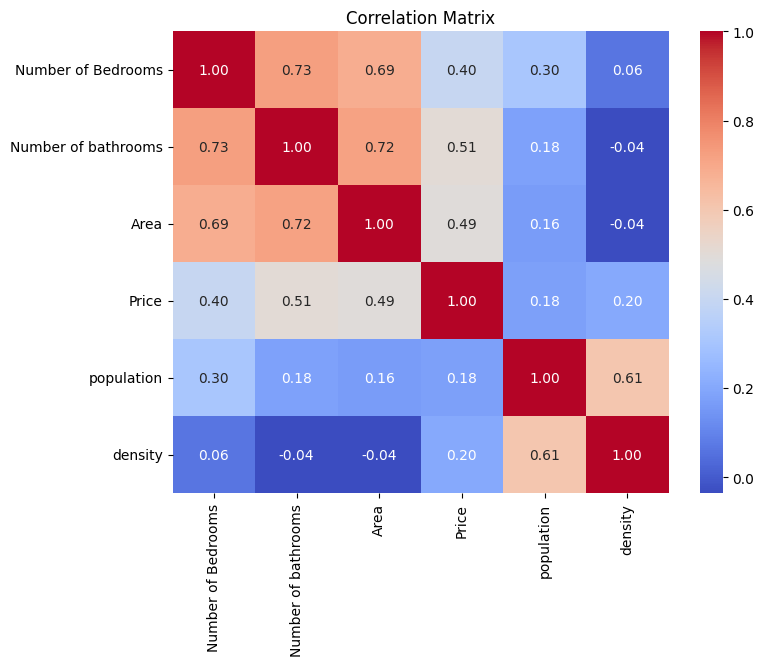

In [10]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()